# Incorporating covariate information into classifiers

Daniel has shown that the sample data possesses covariates in <a href='https://github.com/cognoma/cancer-data/blob/master/3.explore-mutations.ipynb'>this notebook</a>. These may provide a spurious signal that a classifier accommodates for, and could confound attempts to pick out the actual signal we desire. This notebook will create a file with encoded information on these covariates that can be used as additional data to train on.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
%matplotlib inline

Let's peak at the sample data.

In [2]:
samples_df = pd.read_table('download/samples.tsv', index_col=0)
samples_df.head(10)

,patient_id,sample_type,disease,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free
sample_id,,,,,,,,,,
TCGA-02-0047-01,TCGA-02-0047,Primary Tumor,glioblastoma multiforme,Brain,Male,78.0,1.0,448.0,NaN,NaN
TCGA-02-0055-01,TCGA-02-0055,Primary Tumor,glioblastoma multiforme,Brain,Female,62.0,1.0,76.0,NaN,NaN
TCGA-02-2483-01,TCGA-02-2483,Primary Tumor,glioblastoma multiforme,Brain,Male,43.0,0.0,466.0,NaN,NaN
TCGA-02-2485-01,TCGA-02-2485,Primary Tumor,glioblastoma multiforme,Brain,Male,53.0,0.0,470.0,NaN,NaN
TCGA-02-2486-01,TCGA-02-2486,Primary Tumor,glioblastoma multiforme,Brain,Male,64.0,0.0,493.0,NaN,NaN
TCGA-04-1348-01,TCGA-04-1348,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,44.0,1.0,1483.0,NaN,NaN
TCGA-04-1357-01,TCGA-04-1357,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,52.0,NaN,NaN,NaN,NaN
TCGA-04-1362-01,TCGA-04-1362,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,59.0,1.0,1348.0,NaN,NaN
TCGA-05-4244-01,TCGA-05-4244,Primary Tumor,lung adenocarcinoma,Lung,Male,70.0,NaN,NaN,NaN,NaN


Let's get a sense of how much missing data there is.

In [3]:
print('Total number of samples: %d' % len(samples_df))
print('Number of nulls in each column:')
samples_df.isnull().sum(axis=0)

Total number of samples: 7306
Number of nulls in each column:


patient_id                 0
sample_type                0
disease                    0
organ_of_origin            0
gender                    19
age_diagnosed             50
dead                     111
days_survived            111
recurred                1638
days_recurrence_free    1638
dtype: int64

Now count the number of types of each column. We'll use Python's set, and therefore must exclude null values.

In [4]:
categorical_variables = samples_df.columns[[1, 2, 3, 4, 6, 8]]
for variable in categorical_variables:
    not_null = ~samples_df[variable].isnull()
    count = len(set(samples_df.loc[not_null, variable]))
    print('Number of types in category %s: %d' % (variable, count))

Number of types in category sample_type: 1
Number of types in category disease: 32
Number of types in category organ_of_origin: 28
Number of types in category gender: 2
Number of types in category dead: 2
Number of types in category recurred: 2


There are no missing values from <code>sample_types</code> and only one possible value, so it is redundant and we'll exclude it.

In [5]:
categorical_variables = categorical_variables[1:]
print(categorical_variables)

Index(['disease', 'organ_of_origin', 'gender', 'dead', 'recurred'], dtype='object')


Inspecting the head of the samples DataFrame above, we see that two columns, namely <code>dead</code> and <code>recurred</code>, need some attention. We're going to encode categorical variables using panda's get_dummies. Since these columns are indicated by a 1 or 0, this will become the column header when encoded, as below.

In [6]:
pd.get_dummies(samples_df.dead).head(10)

,0.0,1.0
sample_id,,
TCGA-02-0047-01,0.0,1.0
TCGA-02-0055-01,0.0,1.0
TCGA-02-2483-01,1.0,0.0
TCGA-02-2485-01,1.0,0.0
TCGA-02-2486-01,1.0,0.0
TCGA-04-1348-01,0.0,1.0
TCGA-04-1357-01,0.0,0.0
TCGA-04-1362-01,0.0,1.0
TCGA-05-4244-01,0.0,0.0


Note that null values are encoded as (0,0) pairs... I was wondering if we were okay with this.

Let's rename the values in each of these so that they more accurately reflect the underlying variable.

In [7]:
mortality_map = pd.Series(['alive', 'dead'], index=[0.0, 1.0])
mortality = samples_df.dead.map(mortality_map)
mortality.head(10)

sample_id
TCGA-02-0047-01     dead
TCGA-02-0055-01     dead
TCGA-02-2483-01    alive
TCGA-02-2485-01    alive
TCGA-02-2486-01    alive
TCGA-04-1348-01     dead
TCGA-04-1357-01      NaN
TCGA-04-1362-01     dead
TCGA-05-4244-01      NaN
TCGA-05-4249-01    alive
Name: dead, dtype: object

In [8]:
recurred_map = pd.Series(['has_not_recurred', 'has_recurred'], index=[0.0, 1.0])
recurred = samples_df.recurred.map(recurred_map)
recurred.head(10)

sample_id
TCGA-02-0047-01                 NaN
TCGA-02-0055-01                 NaN
TCGA-02-2483-01                 NaN
TCGA-02-2485-01                 NaN
TCGA-02-2486-01                 NaN
TCGA-04-1348-01                 NaN
TCGA-04-1357-01                 NaN
TCGA-04-1362-01                 NaN
TCGA-05-4244-01                 NaN
TCGA-05-4249-01    has_not_recurred
Name: recurred, dtype: object

Now when we concatenate, the columns are appropriately named, and the values are encoded as numeric data that can be input to the types of classifiers that we have been using.

In [9]:
pd.concat([pd.get_dummies(mortality), pd.get_dummies(recurred)], axis=1).head(10)

,alive,dead,has_not_recurred,has_recurred
sample_id,,,,
TCGA-02-0047-01,0.0,1.0,0.0,0.0
TCGA-02-0055-01,0.0,1.0,0.0,0.0
TCGA-02-2483-01,1.0,0.0,0.0,0.0
TCGA-02-2485-01,1.0,0.0,0.0,0.0
TCGA-02-2486-01,1.0,0.0,0.0,0.0
TCGA-04-1348-01,0.0,1.0,0.0,0.0
TCGA-04-1357-01,0.0,0.0,0.0,0.0
TCGA-04-1362-01,0.0,1.0,0.0,0.0
TCGA-05-4244-01,0.0,0.0,0.0,0.0


Let's process the entire thing. We'll convert the categorical variables to dummies, and then concatenate the numeric variables (age of diagnosis, days survived, and days recurrence free).

In [10]:
columns_to_process = [samples_df.disease,
                      samples_df.organ_of_origin,
                      samples_df.gender,
                      mortality,
                      recurred]
columns_as_dummies = [pd.get_dummies(column) for column in columns_to_process]
numeric_columns = ['age_diagnosed', 'days_survived', 'days_recurrence_free']
covariates_df = pd.concat(columns_as_dummies+[samples_df[numeric_columns]], axis=1)
covariates_df.head()

,adrenocortical cancer,bladder urothelial carcinoma,brain lower grade glioma,breast invasive carcinoma,cervical & endocervical cancer,cholangiocarcinoma,colon adenocarcinoma,diffuse large B-cell lymphoma,esophageal carcinoma,glioblastoma multiforme,...,Uterus,Female,Male,alive,dead,has_not_recurred,has_recurred,age_diagnosed,days_survived,days_recurrence_free
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,78.0,448.0,NaN
TCGA-02-0055-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,62.0,76.0,NaN
TCGA-02-2483-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,43.0,466.0,NaN
TCGA-02-2485-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,53.0,470.0,NaN
TCGA-02-2486-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,64.0,493.0,NaN


We may want to do some standardization of column names as before (lower case, underscores).

Let's save this to a <code>.tsv</code> file.

In [11]:
path = os.path.join('download', 'covariates.tsv')
covariates_df.to_csv(path, sep='\t')

Now we'll try to see whether incorporating this information will help to improve the elastic net classifier that was explained at a past meetup.

In [12]:
GENE = '7157' # TP53
path = os.path.join('download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
y = pd.read_table(path, index_col=0)[GENE]

Replicate the classifier...

In [13]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

def gway_classifier(X, y):
    n_feature_kept = 500
    param_fixed = {
        'loss': 'log',
        'penalty': 'elasticnet',
    }
    param_grid = {
        'alpha': [10 ** x for x in range(-6, 1)],
        'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # select the top features with the highest MAD
    feature_select = SelectKBest(fs_mad, k=n_feature_kept)

    # Include loss='log' in param_grid doesn't work with pipeline somehow
    clf = SGDClassifier(random_state=0, class_weight='balanced',
                        loss=param_fixed['loss'], penalty=param_fixed['penalty'])

    # joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
    # Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
    warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
    clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
    pipeline = make_pipeline(
        feature_select,  # Feature selection
        StandardScaler(),  # Feature scaling
        clf_grid)
    pipeline.fit(X=X_train, y=y_train)
    
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)

    metrics_train = get_threshold_metrics(y_train, y_pred_train)
    metrics_test = get_threshold_metrics(y_test, y_pred_test)
    
    return metrics_train, metrics_test

Now run on data with and without covariates. We'll drop the numeric covariates, since they contain Nan's that we haven't handled.

In [14]:
expression_metrics_train, expression_metrics_test = gway_classifier(X, y)
okay_covariates = covariates_df.drop(numeric_columns, axis=1)
covariates_metrics_train, covariates_metrics_test = gway_classifier(pd.concat([X, okay_covariates], axis=1), y)

And plot...

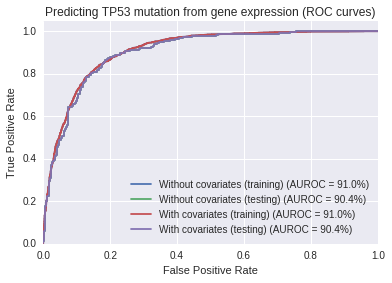

In [15]:
# Plot ROC
plt.figure()
labels = ('Without covariates (training)',
          'Without covariates (testing)',
          'With covariates (training)', 
          'With covariates (testing)')
metrics = (expression_metrics_train,
           expression_metrics_test,
           covariates_metrics_train,
           covariates_metrics_test)
for label, metric in zip(labels, metrics):
    roc_df = metric['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metric['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

Unfortunately, the classifier does not even seem to notice the presence of the covariates. But this could be due to the MAD filtering step, lack of feature normalization, and plenty of other things. Curious to hear thoughts about where to go.